## Import Libraries and Datasets

Below, we imported packages, libaries, and our NSS and RDA datasets. We adjusted certain datasets to reflect households in Bihar only as opposed to the entire country of India.

In [1]:
!pip install eep153_tools
!pip install -r requirements.txt

In [2]:
!pip install pyarrow

Below, we imported and read in all of our household characteristics data from the NSS.

In [3]:
import cfe
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Missing dependencies for OracleDemands.


In [4]:
z =  pd.read_parquet('z.parquet', engine = 'pyarrow')

In [5]:
#q =  pd.read_parquet('q.parquet', engine = 'pyarrow').unstack('j')
q = pd.read_parquet('q.parquet', engine = 'pyarrow').reset_index()
q

,j,i,unit,Frequency,total_quantity
0,410001101,apple,kg,Monthly,250.0
1,410001101,arhar (tur),kg,Monthly,2000.0
2,410001101,besan,kg,Monthly,2000.0
3,410001101,black pepper,gm,Monthly,20.0
4,410001101,brinjal,kg,Monthly,5000.0
...,...,...,...,...,...
4423639,799982301,tomato,kg,Monthly,3000.0
4423640,799982301,turmeric,gm,Monthly,300.0
4423641,799982301,urd,kg,Monthly,1000.0
4423642,799982301,wheat/atta - P.D.S.,kg,Monthly,10000.0


We noticed that some items were incorrectly labeled as being represented in kg when the quantites indicated that they were in grams. In the cell below, we fixed all of the quantities labaled as kg and litres to actually reflect those quantities. 

In [6]:
q['total_quantity'].mask(q['unit'] == 'kg', q['total_quantity'] / 1000, inplace=True)
q['total_quantity'].mask(q['unit'] == 'litre', q['total_quantity'] / 1000, inplace=True)
q

,j,i,unit,Frequency,total_quantity
0,410001101,apple,kg,Monthly,0.25
1,410001101,arhar (tur),kg,Monthly,2.00
2,410001101,besan,kg,Monthly,2.00
3,410001101,black pepper,gm,Monthly,20.00
4,410001101,brinjal,kg,Monthly,5.00
...,...,...,...,...,...
4423639,799982301,tomato,kg,Monthly,3.00
4423640,799982301,turmeric,gm,Monthly,300.00
4423641,799982301,urd,kg,Monthly,1.00
4423642,799982301,wheat/atta - P.D.S.,kg,Monthly,10.00


We also need to make sure that we only include households in Bihar, so we filter out households in other states below.

In [7]:
z_bihar = z[z['m'] == 'Bihar']
bihar_households = z_bihar.index
q_bihar2 = q[q['j'].isin(bihar_households)]
q_bihar2

,j,i,unit,Frequency,total_quantity
1335859,470441101,arhar (tur),kg,Monthly,2.50
1335860,470441101,"biscuits, chocolates",Re,Monthly,0.00
1335861,470441101,black pepper,gm,Monthly,100.00
1335862,470441101,"cake, pastry, prepared sweets",Re,Monthly,0.00
1335863,470441101,cashewnut,kg,Monthly,0.25
...,...,...,...,...,...
3155891,746992301,tea : cups,no.,Monthly,10.00
3155892,746992301,tea : leaf,gm,Monthly,100.00
3155893,746992301,tomato,kg,Monthly,2.00
3155894,746992301,turmeric,gm,Monthly,450.00


In [8]:
x = pd.read_parquet('x.parquet', engine = 'pyarrow').unstack('j')

In [9]:
x_adjusted = x.T.reset_index()
x_bihar = x_adjusted[x_adjusted['j'].isin(bihar_households)]

In [10]:
n =  pd.read_parquet('n.parquet', engine = 'pyarrow')
n = n.rename(columns={'calories per unit(kcal)': 'Calories', 'fat per unit(gm)': 'Fat', 'protein per unit(gm)': 'Protein'})
n

,Calories,Fat,i,Protein,rural,t,unit
1,3280.000000,13.00,ragi,73.00,NaN,50,kg
4,1100.000000,2.00,other cereal subs.,16.00,NaN,50,kg
5,3420.000000,36.00,maize-other sources,111.00,NaN,50,kg
7,3420.000000,36.00,maize - pds,111.00,NaN,50,kg
8,3360.000000,13.00,barley,115.00,NaN,50,kg
...,...,...,...,...,...,...,...
145,24.700001,0.95,other served processed food,0.70,0.0,68,Re
146,21.100000,0.85,"cake, pastry, prepared sweets",0.20,0.0,68,Re
147,28.500000,0.17,"biscuits, chocolates",0.35,0.0,68,Re
148,24.700001,0.95,"papad, bhujia, namkeen, mixture, chanachur",0.70,0.0,68,Re


In [11]:
total_expenditures =  pd.read_parquet('total_expenditures.parquet', engine = 'pyarrow')

### Import RDA Data and Mapping RDA to Households in Bihar
RDA is a dataframe indicating the recommended daily allowances in India. As we see below, RDA includes different age/sex groups and ranges than what we see in our household data. So, we created a dataframe, rda_fixed, that shows the recommended daily allowances in India corresponding to the age/sex categories in the datasets we imported above.

In [12]:
rda = pd.read_pickle('indian_rda.df').T 
rda = rda.replace('', np.nan)
rda

,C 0-0.5,C 0.5-1,C 1-3,C 4-6,C 7-9,B 10-12,G 10-12,B 13-15,G 13-15,B 16-17,G 16-17,M,W
Calories,NaN,NaN,1060.0,1350.0,1690.0,2190.0,2010.0,2750.0,2330.0,3020.0,2440.0,2730.0,2230.0
Protein,NaN,NaN,16.7,20.1,29.5,39.9,40.4,54.3,51.9,61.5,55.5,60.0,55.0
Fat,NaN,19.0,27.0,25.0,30.0,35.0,35.0,45.0,40.0,50.0,35.0,30.0,25.0
Calcium,500.0,500.0,600.0,600.0,600.0,800.0,800.0,800.0,800.0,800.0,800.0,600.0,1200.0
Iron,NaN,5.0,9.0,13.0,16.0,21.0,27.0,32.0,27.0,28.0,26.0,17.0,21.0
Betacarotene,NaN,2800.0,3200.0,3200.0,4800.0,4800.0,4800.0,4800.0,4800.0,4800.0,4800.0,4800.0,4800.0
Thiamine,0.2,0.3,0.5,0.7,0.8,1.1,1.0,1.4,1.2,1.5,1.0,1.4,1.1
Riboflavin,0.3,0.4,0.6,0.8,1.0,1.3,1.2,1.6,1.4,1.8,1.2,1.4,1.3
Niacin,NaN,NaN,8.0,11.0,13.0,15.0,13.0,16.0,14.0,17.0,14.0,18.0,14.0
Ascorbic Acid,25.0,25.0,40.0,40.0,40.0,40.0,40.0,40.0,40.0,40.0,40.0,40.0,40.0


In [13]:
rda_fixed = pd.DataFrame(index = rda.index)
rda_fixed['Males 60-100'] = rda['M'].to_list()
rda_fixed['Males 50-60'] = rda['M'].to_list()
rda_fixed['Males 30-50'] = rda['M'].to_list()
rda_fixed['Males 20-30'] = rda['M'].to_list()
rda_fixed['Males 15-20'] = (np.array(rda['M']) + np.array(rda['B 16-17'])) / 2
rda_fixed['Males 10-15'] = (np.array(rda['B 10-12']) + np.array(rda['B 13-15'])) / 2
rda_fixed['Males 5-10'] = (np.array(rda['C 4-6']) + np.array(rda['C 7-9'])) / 2
rda_fixed['Males 1-5'] = (np.array(rda['C 1-3']) + np.array(rda['C 4-6'])) / 2
rda_fixed['Males 0-1'] = (np.array(rda['C 0-0.5']) + np.array(rda['C 0.5-1'])) / 2
rda_fixed['Females 60-100'] = rda['W'].to_list()
rda_fixed['Females 50-60'] = rda['W'].to_list()
rda_fixed['Females 30-50'] = rda['W'].to_list()
rda_fixed['Females 20-30'] = rda['W'].to_list()
rda_fixed['Females 15-20'] = (np.array(rda['W']) + np.array(rda['G 16-17'])) / 2
rda_fixed['Females 10-15'] = (np.array(rda['G 10-12']) + np.array(rda['G 13-15'])) / 2
rda_fixed['Females 5-10'] = (np.array(rda['C 4-6']) + np.array(rda['C 7-9'])) / 2
rda_fixed['Females 1-5'] = (np.array(rda['C 1-3']) + np.array(rda['C 4-6'])) / 2
rda_fixed['Females 0-1'] = (np.array(rda['C 0-0.5']) + np.array(rda['C 0.5-1'])) / 2
rda_fixed

,Males 60-100,Males 50-60,Males 30-50,Males 20-30,Males 15-20,Males 10-15,Males 5-10,Males 1-5,Males 0-1,Females 60-100,Females 50-60,Females 30-50,Females 20-30,Females 15-20,Females 10-15,Females 5-10,Females 1-5,Females 0-1
Calories,2730.0,2730.0,2730.0,2730.0,2875.00,2470.00,1520.00,1205.0,NaN,2230.0,2230.0,2230.0,2230.0,2335.00,2170.00,1520.00,1205.0,NaN
Protein,60.0,60.0,60.0,60.0,60.75,47.10,24.80,18.4,NaN,55.0,55.0,55.0,55.0,55.25,46.15,24.80,18.4,NaN
Fat,30.0,30.0,30.0,30.0,40.00,40.00,27.50,26.0,NaN,25.0,25.0,25.0,25.0,30.00,37.50,27.50,26.0,NaN
Calcium,600.0,600.0,600.0,600.0,700.00,800.00,600.00,600.0,500.00,1200.0,1200.0,1200.0,1200.0,1000.00,800.00,600.00,600.0,500.00
Iron,17.0,17.0,17.0,17.0,22.50,26.50,14.50,11.0,NaN,21.0,21.0,21.0,21.0,23.50,27.00,14.50,11.0,NaN
Betacarotene,4800.0,4800.0,4800.0,4800.0,4800.00,4800.00,4000.00,3200.0,NaN,4800.0,4800.0,4800.0,4800.0,4800.00,4800.00,4000.00,3200.0,NaN
Thiamine,1.4,1.4,1.4,1.4,1.45,1.25,0.75,0.6,0.25,1.1,1.1,1.1,1.1,1.05,1.10,0.75,0.6,0.25
Riboflavin,1.4,1.4,1.4,1.4,1.60,1.45,0.90,0.7,0.35,1.3,1.3,1.3,1.3,1.25,1.30,0.90,0.7,0.35
Niacin,18.0,18.0,18.0,18.0,17.50,15.50,12.00,9.5,NaN,14.0,14.0,14.0,14.0,14.00,13.50,12.00,9.5,NaN
Ascorbic Acid,40.0,40.0,40.0,40.0,40.00,40.00,40.00,40.0,25.00,40.0,40.0,40.0,40.0,40.00,40.00,40.00,40.0,25.00


Now that we have a dataframe detailing the recommended daily intakes with the same age/sex groups as our imported dataset, we want to do a matrix multiplication of this dataframe and z_bihar_ages, which tells us how many people are in each age/sex group per household.

In [14]:
z_bihar_ages = z_bihar.iloc[:, 4:]
z_bihar_ages.to_numpy()

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 1, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 2, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 1, 0, 0]])

In [15]:
transposed_rda = rda_fixed.reset_index().rename(columns={'index': 'Nutrition'}).drop(['Nutrition'], axis=1).T
transposed_rda = transposed_rda.to_numpy()
transposed_rda

array([[2.730e+03, 6.000e+01, 3.000e+01, 6.000e+02, 1.700e+01, 4.800e+03,
        1.400e+00, 1.400e+00, 1.800e+01, 4.000e+01],
       [2.730e+03, 6.000e+01, 3.000e+01, 6.000e+02, 1.700e+01, 4.800e+03,
        1.400e+00, 1.400e+00, 1.800e+01, 4.000e+01],
       [2.730e+03, 6.000e+01, 3.000e+01, 6.000e+02, 1.700e+01, 4.800e+03,
        1.400e+00, 1.400e+00, 1.800e+01, 4.000e+01],
       [2.730e+03, 6.000e+01, 3.000e+01, 6.000e+02, 1.700e+01, 4.800e+03,
        1.400e+00, 1.400e+00, 1.800e+01, 4.000e+01],
       [2.875e+03, 6.075e+01, 4.000e+01, 7.000e+02, 2.250e+01, 4.800e+03,
        1.450e+00, 1.600e+00, 1.750e+01, 4.000e+01],
       [2.470e+03, 4.710e+01, 4.000e+01, 8.000e+02, 2.650e+01, 4.800e+03,
        1.250e+00, 1.450e+00, 1.550e+01, 4.000e+01],
       [1.520e+03, 2.480e+01, 2.750e+01, 6.000e+02, 1.450e+01, 4.000e+03,
        7.500e-01, 9.000e-01, 1.200e+01, 4.000e+01],
       [1.205e+03, 1.840e+01, 2.600e+01, 6.000e+02, 1.100e+01, 3.200e+03,
        6.000e-01, 7.000e-01, 9.500e+

nutrition_by_house is a dataframe that tells us the recommended daily allowances per household, based on the specific individuals in that household (i.e. their ages, how many people there are, etc). 

In [16]:
nutrition_by_house = z_bihar_ages.dot(transposed_rda)
nutrition_by_house.columns = rda_fixed.index
nutrition_by_house

,Calories,Protein,Fat,Calcium,Iron,Betacarotene,Thiamine,Riboflavin,Niacin,Ascorbic Acid
j,,,,,,,,,,
470441101,NaN,NaN,NaN,1900.0,NaN,NaN,2.80,3.20,NaN,120.0
470441102,NaN,NaN,NaN,2300.0,NaN,NaN,3.95,4.50,NaN,120.0
470441201,NaN,NaN,NaN,5500.0,NaN,NaN,7.95,8.80,NaN,280.0
470441202,NaN,NaN,NaN,3000.0,NaN,NaN,5.70,6.00,NaN,200.0
470441203,NaN,NaN,NaN,3800.0,NaN,NaN,4.75,5.55,NaN,200.0
...,...,...,...,...,...,...,...,...,...,...
746991301,NaN,NaN,NaN,2700.0,NaN,NaN,3.90,4.45,NaN,160.0
746992101,NaN,NaN,NaN,5300.0,NaN,NaN,5.05,6.05,NaN,225.0
746992201,NaN,NaN,NaN,5900.0,NaN,NaN,7.10,8.30,NaN,280.0


Next, we then merged our nutrient dataset and q_bihar to create q_bihar_n, which describes the total_quantity, calorie, fat per unit, and protein per unit intake for each food item in each household.

It should be noted that the calorie, fat, and protein quantites given in n correspond to 1 kg of each food item. To get the right calorie, protein, and fat amounts, we multiplied each of these values by the total_quantity corresponding to that household.

In [17]:
q_bihar_n = q_bihar2.merge(n, left_on='i', right_on='i')
q_bihar_n['total_quantity'] = q_bihar_n['total_quantity']
for row in range(len(q_bihar_n)):
    q_bihar_n.loc[row, 'Calories'] = q_bihar_n.loc[row, 'Calories'] * q_bihar_n.loc[row, 'total_quantity']
    q_bihar_n.loc[row, 'Fat'] = q_bihar_n.loc[row, 'Fat'] * q_bihar_n.loc[row, 'total_quantity']
    q_bihar_n.loc[row, 'Protein'] = q_bihar_n.loc[row, 'Protein'] * q_bihar_n.loc[row, 'total_quantity']
q_bihar_n

,j,i,unit_x,Frequency,total_quantity,Calories,Fat,Protein,rural,t,unit_y
0,470441101,arhar (tur),kg,Monthly,2.5,8375.0,42.5,557.5,0.0,68,kg
1,470441102,arhar (tur),kg,Monthly,1.0,3350.0,17.0,223.0,0.0,68,kg
2,470441201,arhar (tur),kg,Monthly,3.0,10050.0,51.0,669.0,0.0,68,kg
3,470441203,arhar (tur),kg,Monthly,2.0,6700.0,34.0,446.0,0.0,68,kg
4,470441204,arhar (tur),kg,Monthly,1.0,3350.0,17.0,223.0,0.0,68,kg
...,...,...,...,...,...,...,...,...,...,...,...
217323,745712101,small millets & products,kg,Monthly,3.0,7845.0,102.0,291.0,0.0,68,kg
217324,745712202,small millets & products,kg,Monthly,2.0,5230.0,68.0,194.0,0.0,68,kg
217325,745712301,small millets & products,kg,Monthly,2.0,5230.0,68.0,194.0,0.0,68,kg
217326,743292101,jowar & products,kg,Monthly,2.0,6980.0,38.0,208.0,0.0,68,kg


# Nutritional Systems, Challenges, & Adequacy of Food Demands - [A]

zbar is the proportion of households in Bihar that have each of the age/sex groups shown below.

In [18]:
zbar = z_bihar.mean(axis=0)
zbar

/tmp/ipykernel_184/1843868859.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  zbar = z_bihar.mean(axis=0)


k
Males 0-1         0.028154
Males 1-5         0.235050
Males 5-10        0.352248
Males 10-15       0.370581
Males 15-20       0.328677
Males 20-30       0.442165
Males 30-50       0.661502
Males 50-60       0.192056
Males 60-100      0.202750
Females 0-1       0.023352
Females 1-5       0.211698
Females 5-10      0.300087
Females 10-15     0.299651
Females 15-20     0.225011
Females 20-30     0.401571
Females 30-50     0.634221
Females 50-60     0.181580
Females 60-100    0.150153
dtype: float64

Now, the inner/dot/matrix product between zbar and the rda_fixed DataFrame of requirements will give us minimum requirements for the average household:

In [19]:
# May need to tweak types or alignment to match RDA and zbar types:
rda0,zbar0=rda_fixed.align(zbar,axis=1) #this method allows us to align columns if there's a different order 

# This matrix product gives minimum nutrient requirements for average
hh_rda = rda0.replace(np.nan,0)@zbar0
# RDA is /daily/, but  demands in ICRISAT data are /monthly/:
hh_rda = hh_rda 
hh_rda #large numbers of calories because it shows calorie intake at household level, 11706 calories is in line with average number of people in household

Calories         11706.215626
Protein            253.202532
Fat                154.654518
Calcium           4216.586643
Iron                99.159101
Betacarotene     23670.536883
Thiamine             5.878001
Riboflavin           6.527532
Niacin              76.881275
Ascorbic Acid      208.847665
dtype: float64

The numbers may seem large but they are in-line with average household sizes in Bihar. For example, 11706 calories is in line with average number of people in household. 

Below, we see the prices of food items. 

Note: the multiplication by 1000 was a recommendation given to us in class due to unit conversion issues from the dataset we imported. This allows us to properly reflect the prices of food items.

In [21]:
r = cfe.result.from_dataset('phat.ds',engine='netcdf4')
UseNutrients=['Protein','Calories','Fat']

# Reference period, market
t,m = 1,1 

# Reference budget (find mean in reference period & market):
reference_x = r.get_predicted_expenditures().mean('j').sum('i').sel(m=m)

p = r.prices.sel(m=m,drop=True) *1000 #multiplied by 1000 based on recommendation discussed in class due to unit conversion issues
p = p.to_dataframe('i').squeeze().dropna()
p.index = p.index.droplevel()
p

i
apple                                                75.035218
arhar (tur)                                          75.512012
besan                                                60.223086
bread (bakery)                                       49.760239
brinjal                                              14.824339
cabbage                                              10.303940
cauliflower                                          12.187999
chicken                                             121.697776
chillis (green)                                      46.695197
chira                                                24.698367
firewood & chips                                      5.032111
fish ( fresh )                                      107.222192
french beans and barbati                             18.851989
goat meat                                           256.171869
gourd, pumpkin                                        9.990976
gram (split)                                         

In the next few cells, we are cleaning our datasets so that all food items match and we drop any duplicates.

In [22]:
n = n.set_index('i').drop(['rural', 't', 'unit'], axis=1)
n = n[n.index.isin(p.index)]
#n = n.drop(labels=['peas-vegetables'])
n

,Calories,Fat,Protein
i,,,
potato,970.0,1.0,16.0
rice - P.D.S.,3460.0,5.0,75.0
rice - other sources,3460.0,5.0,75.0
chira,3460.0,12.0,66.0
muri,3250.0,1.0,75.0
wheat/atta - P.D.S.,3410.0,17.0,121.0
wheat/atta - other sources,3410.0,17.0,121.0
maida,3480.0,9.0,110.0
"suji, rawa",3480.0,8.0,104.0


In [23]:
def my_prices(p0,p=p,i='Coconut'): #utility function
    p = p.copy()
    p.loc[i] = p0
    return p

In [24]:
p = p.drop(labels=['firewood & chips', 'lpg']) #dropping items from p and n that are not in both or are duplicates
p = p.drop(labels=['salt ', 'peas-vegetables'])

In [25]:
n = n.drop(labels=['peas-vegetables'])

In [26]:
len(n.index), len(p.index) #sanity check, make sure that items in p and n are the same -- important to generating our plots!

(42, 42)

### Nutrient Demand 
 
 

In [27]:
import warnings 

def nutrient_demand(x,p): 
    with warnings.catch_warnings(): #gets rids of messy warnings
        warnings.simplefilter("ignore")
        c = r.demands(x,p) #compute quantities demand for all food

    n0,c0 = n.align(c,axis=0,join='inner') #alignment trick
    
    N = n0.T@c0 #takes quantities demand (c0) and multiplies by fct0

    N = N.loc[~N.index.duplicated()]
    
    return N/7

Text(0, 0.5, 'log nutrient')

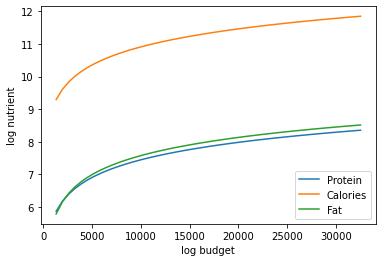

In [28]:
import numpy as np
import matplotlib.pyplot as plt

X = np.linspace(reference_x/5,reference_x*5,50)
X = X.flatten()

UseNutrients = ['Protein','Calories','Fat']

df = pd.concat({myx:np.log(nutrient_demand(myx,p))[UseNutrients] for myx in X},axis=1).T
ax = df.plot()

ax.set_xlabel('log budget') 
ax.set_ylabel('log nutrient')

First, we constructed Engel curves of protein, calories, and fat. These curves represent the quantities demanded of these nutrients at various levels of income, when prices and preferences are held constant. It’s also important to note the upward slope, which indicates normal and essential goods as opposed to inferior goods. 

In [29]:
r.get_beta(as_df=True).sort_values() # this allows us to see which goods are the most elastic/inelastic

i
maize & products                             -0.058078
kerosene-pds                                 -0.014995
rice - P.D.S.                                 0.017503
matches                                       0.030918
wheat/atta - P.D.S.                           0.036592
                                                ...   
papad, bhujia, namkeen, mixture, chanachur    0.455317
orange,mausami                                0.456468
other fresh fruits                            0.474922
apple                                         0.505788
cake, pastry, prepared sweets                 0.520278
Name: beta, Length: 82, dtype: float64

Text(0.5, 1.0, 'log price vs log nutrient of apples')

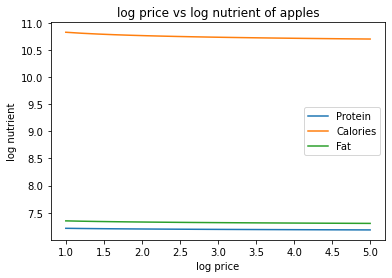

In [30]:
USE_GOOD = "apple"

ref_price = r.prices.sel(i=USE_GOOD,m=m,drop=True)

P = np.linspace(1,5,20).tolist()

ndf = pd.DataFrame({p0:np.log(nutrient_demand(reference_x,my_prices(p0,i=USE_GOOD)))[UseNutrients] for p0 in P}).T

ax = ndf.plot()

ax.set_xlabel('log price')
ax.set_ylabel('log nutrient') 
plt.title('log price vs log nutrient of apples')

Text(0.5, 1.0, 'log price vs log nutrient of potato')

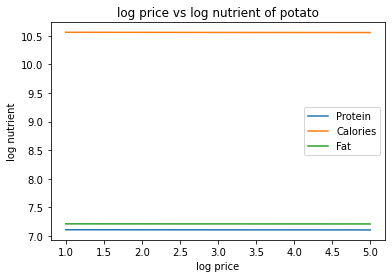

In [31]:
USE_GOOD = "potato"

ref_price = r.prices.sel(i=USE_GOOD,m=m,drop=True)

P = np.linspace(1,5,20).tolist()

ndf = pd.DataFrame({p0:np.log(nutrient_demand(reference_x,my_prices(p0,i=USE_GOOD)))[UseNutrients] for p0 in P}).T

ax = ndf.plot()

ax.set_xlabel('log price')
ax.set_ylabel('log nutrient') 
plt.title('log price vs log nutrient of potato')

Above, we looked at how nutrition varies with prices for a given food item. We can see a a downwards slope to reflect the demand of these different nutrients in apples. Even the most elastic item in our dataset, apple, looks relatively inelastic, so this tells us is that food items consumed by households in Bihar are staple goods and are really hard to substitute for, which is one thing to keep in mind when we think about what policy goals we want to implement.

### Nutritional Adequacy

In [32]:
def nutrient_adequacy_ratio(x,p):
    return nutrient_demand(x,p)/hh_rda #greater than 1 = adequate, less than 1 = less than adequate bc log of ratios

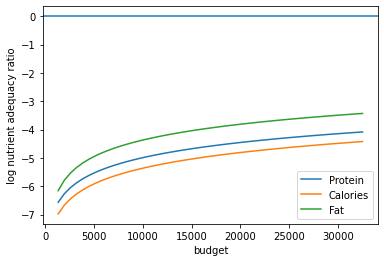

In [33]:
X = np.linspace(reference_x/5,reference_x*5,50)
X = X.flatten()
ndf = pd.concat({x:np.log(nutrient_adequacy_ratio(x,p))[UseNutrients] for x in X},axis=1).T

ax = (ndf-np.log(1000)).plot()

ax.set_xlabel('budget')
ax.set_ylabel('log nutrient adequacy ratio')
ax.axhline(0)


As we can see from the plot above, it appears that households in this region would require around 7000 rupees to consume an adequate amount of claories and protein. They would require around 2500 rupees to consume an adequate amount of fat. To get a sense of how many households are able to meet this budget, we analyzed our total_expenditures dataset, which details how much each household in Bihar spends per month on food items. 

We can see in our code blocks below that the average household spends around 4334 rupees per month, and that 75% households spend less than 5333 rupees per month. The histogram below also indicates how many households are in each budget bin, and we can see that most households in our dataset spend less than 7000 rupees. 

In [34]:
total_expenditures['total_value'].describe()

count    101660.000000
mean       4334.352912
std        2740.356807
min           5.000000
25%        2746.000000
50%        3867.000000
75%        5333.250000
max      213160.000000
Name: total_value, dtype: float64

Text(0, 0.5, 'Number of Households')

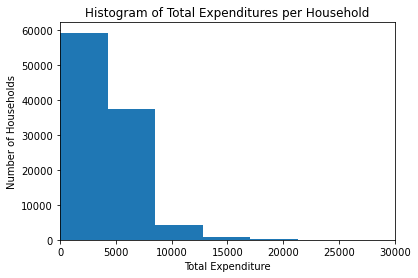

In [35]:
plt.hist(total_expenditures['total_value'],bins=50 )
plt.xlim(0,30000)
plt.title('Histogram of Total Expenditures per Household')
plt.xlabel('Total Expenditure')
plt.ylabel('Number of Households')

It should be noted that our plots and analyses generated above are based on our n dataframe, which is the nutrients dataframe provided for us from the NSS data. The only nutrients included are protein, fat, and calories. To form a more complete analysis and get a better understanding of the nutritional adequacy of households in Bihar, we would like to look at other nutrients as well. We will do this by converting our food items into nutrients using FDC codes, as we have done in project 2, and (for some members our group as well) in project 3.

# Food Conversion Table & Nutritional Systems, Challenges, & Adequacy of Food Demands Part II (more nutrients) - [A]

We found the fdc IDs of each food item in our n dataset, imported below as fdc_codes.

In [36]:
fdc_codes = pd.read_csv('proj_3_fdc_codes.csv').set_index('Item')
fdc_codes = fdc_codes.reset_index()
fdc_codes

,Item,ID
0,apple,1102644
1,arhar (tur),1977550
2,baby food,1102843
3,bajra & products,1799770
4,banana,1102653
...,...,...
90,urd,1898206
91,"vanaspati, margarine",1103828
92,walnut,2118446
93,watermelon,1102698


In [37]:
fdc_codes = fdc_codes[fdc_codes['Item'].isin(n.index)] #make sure to include items in the n dataset above
len(fdc_codes)

31

In [38]:
estimated_quantities = q_bihar_n.groupby('i').mean()
estimated_quantities = estimated_quantities[estimated_quantities.index.isin(fdc_codes['Item'])]
estimated_quantities.head()

,total_quantity,Calories,Fat,Protein,rural
i,,,,,
apple,1.318311,777.803582,6.591556,2.636622,0.0
arhar (tur),1.568844,5255.627168,26.670347,349.852197,0.0
besan,0.552420,1878.228893,6.629043,121.532458,0.0
bread (bakery),0.775502,1899.980619,5.428516,60.489179,0.0
brinjal,2.385902,572.616393,7.157705,33.402623,0.0


The FDC measures items in hectograms. We first check that all of our items in estimated_quantities, that we are passing into the FDC/API code block are all in kilograms. Since they are all in kilograms, we can multiply them all by 10 to obtain the values in hectograms.

In [39]:
estimated_quantities.index.isin(q_bihar_n[q_bihar_n['unit_x'] != 'kg']['i'].unique()) 
#this indicates that all items being passed into FDC code block are already in kg


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False])

In [40]:
Q = fdc_codes
Q['Quantity'] = estimated_quantities['total_quantity'].to_list()
Q['Quantity'] = Q['Quantity'] * 10 #convert to hectograms
Q = Q.reset_index()
Q.head() #Q is a dataframe that indicates quantities of each item in fdc_codes

/tmp/ipykernel_184/1755895815.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Q['Quantity'] = estimated_quantities['total_quantity'].to_list()
/tmp/ipykernel_184/1755895815.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Q['Quantity'] = Q['Quantity'] * 10 #convert to hectograms


,index,Item,ID,Quantity
0,0,apple,1102644,13.183112
1,1,arhar (tur),1977550,15.688439
2,9,besan,2091506,5.524203
3,11,bread (bakery),1100621,7.755023
4,12,brinjal,2024758,23.859016


After matching all of the food items across the different dataframes for uniformity, we ran the following cell to produce a dataframe that has the nutritional content of each food item we're looking at. We will use the information in this dataframe to map the nutrients to the predicted consumption per household, qhat.

In [41]:
import fooddatacentral as fdc
apikey = 'CDXgPa1HVqJab8EFllem1ikOF75m2ELYwziKtICr'
D = {}
count = 0
for food in Q.Item.tolist():
    try:
        FDC = Q.loc[Q.Item==food,:].ID[count]
        count+=1
        print(FDC)
        D[food] = fdc.nutrients(apikey,FDC).Quantity
    except AttributeError: 
        warnings.warn("Couldn't find FDC Code %s for food %s." % (food,FDC))        

D = pd.DataFrame(D,dtype=float).fillna(0)

D

1102644
1977550
2091506
1100621
2024758
1103343
1103345
2029648
170497
2216557
175304
168448
1100536
1102666
1942595
2008520
2091229
2155640
172420
1100404
172337
1103364
1103153
1102879
1103374
2129576
2077766
1126152
1103276
1103828
522973


,apple,arhar (tur),besan,bread (bakery),brinjal,cabbage,cauliflower,chicken,chillis (green),french beans and barbati,...,onion,palak,potato,radish,"refined oil [sunflower, soyabean, saffola, etc.]",rice - other sources,"suji, rawa",tomato,"vanaspati, margarine",wheat/atta - other sources
Alanine,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.082,0.0,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0
"Alcohol, ethyl",0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.000,0.0,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0
Amino acids,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.000,0.0,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0
Arginine,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.096,0.0,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0
Ash,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.600,0.0,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Vitamin K (Dihydrophylloquinone),0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.000,0.0,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0
Vitamin K (phylloquinone),2.20,0.0,0.0,0.20,0.0,38.20,15.50,0.0,14.300,0.0,...,0.40,178.00,4.10,1.30,0.0,0.0,0.0,7.90,101.30,0.0
Vitamins and Other Components,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.000,0.0,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0
Water,85.56,0.0,0.0,35.70,0.0,90.39,92.07,0.0,87.740,0.0,...,89.11,82.03,72.09,95.27,0.0,0.0,0.0,94.52,37.58,0.0


### Actual Predicted Consumption

Below, we matrix multiplied qhat and our mapped nutrients from above, D, to construct a dataframe that gives us the predicted consumption of nutrients for households in Bihar. We found the mean consumptions for each nutrient below.

In [44]:
qhat = pd.read_csv('qhat.csv')
qhat = qhat.set_index(['t', 'm', 'j'])
qhat.head()

apple  arhar (tur)  banana       besan  \
t m j                                                         
1 1 470441101  2639.995325  1659.125400     NaN  726.465664   
    470441102  1042.342338  1136.653880     NaN  448.704296   
    470441201  1047.269911  1482.081243     NaN  636.119070   
    470441202  1368.947645  1495.042945     NaN  627.090476   
    470441203  1178.226715  1569.226732     NaN  536.378372   

               biscuits, chocolates  black pepper  bread (bakery)  \
t m j                                                               
1 1 470441101                   NaN           NaN      640.673689   
    470441102                   NaN           NaN      520.619697   
    470441201                   NaN           NaN      722.342601   
    470441202                   NaN           NaN      670.925393   
    470441203                   NaN           NaN      566.039238   

                   brinjal      cabbage  cake, pastry, prepared sweets  ...  \
t m j                                                                   ...   
1 1 470441101  2804.504727  3002.372978                            NaN  ...   
    470441102  1903.614296  2050.762277                            NaN  ...   
    470441201  2724.921981  3024.971187                            NaN  ...   
    470441202  2597.196392  2752.571949                            NaN  ...   
    470441203  2397.189358  2426.329423                            NaN  ...   

               sewai, noodles  sugar - other sources  suji, rawa  tea : cups  \
t m j                                                                          
1 1 470441101      646.271095            3484.198321  913.260804         NaN   
    470441102      451.076979            1976.960460  591.110329         NaN   
    470441201      501.180769            3182.126511  812.989933         NaN   
    470441202      580.936474            3083.668613  799.348157         NaN   
    470441203      508.116536            3047.975725  716.216142         NaN   

               tea : leaf       tomato  turmeric  vanaspati, margarine  \
t m j                                                                    
1 1 470441101         NaN  2807.114109       NaN            695.123155   
    470441102         NaN  1435.139514       NaN            364.110379   
    470441201         NaN  1850.249515       NaN            493.759679   
    470441202         NaN  2171.984762       NaN            521.776751   
    470441203         NaN  1757.453362       NaN            557.292136   

               wheat/atta - P.D.S.  wheat/atta - other sources  
t m j                                                           
1 1 470441101         10352.186018                23221.854219  
    470441102          9155.209342                17634.644634  
    470441201         10389.639345                34192.794413  
    470441202         10814.960997                28368.361167  
    470441203         10384.087530                30632.773950  

[5 rows x 82 columns]

In [45]:
food_list = qhat.columns.values.tolist()
d_list = D.columns.values.tolist()

#cross filter and match the two dfs; replace NaN values with 0 
final_q = qhat.filter(items=d_list).replace(np.nan,0)/30 #convert monthly predicted intak to daily 
final_d = D.filter(items=food_list).replace(np.nan,0)

In [46]:
actual_mean_consumption = final_q@final_d.T 
actual_mean_consumption = actual_mean_consumption.rename(columns={'Calcium, Ca': 'Calcium', 'Iron, Fe': 'Iron', 'Energy': 'Calories', 'Carotene, beta': 'Betacarotene', 
                               'Total lipid (fat)': 'Fat', 'Thiamin': 'Thiamine', 'Vitamin C, total ascorbic acid': 'Ascorbic Acid'
                              
                              })
actual_mean_consumption = actual_mean_consumption.mean(axis=0)
actual_mean_consumption

Alanine                                58.997194
Alcohol, ethyl                          0.000000
Amino acids                             0.000000
Arginine                              174.002802
Ash                                   272.477552
                                        ...     
Vitamin K (Dihydrophylloquinone)        0.000000
Vitamin K (phylloquinone)           23504.903431
Vitamins and Other Components           0.000000
Water                               92990.432839
Zinc, Zn                              692.980748
Length: 114, dtype: float64

In [47]:
actual_consumption = final_q@final_d.T 
actual_consumption
#actual_consumption.to_csv('actual_consumption.csv') #outputted to csv to share with other members of project who used them to create maps

Alanine  Alcohol, ethyl  Amino acids    Arginine         Ash  \
t m j                                                                           
1 1 470441101  58.822064             0.0          0.0  204.936791  319.049083   
    470441102  50.997527             0.0          0.0  152.707737  239.805991   
    470441201  74.802146             0.0          0.0  238.148362  355.260301   
    470441202  68.593702             0.0          0.0  204.436777  326.690298   
    470441203  66.665225             0.0          0.0  200.154241  302.048625   
...                  ...             ...          ...         ...         ...   
    746991301  54.091609             0.0          0.0  157.154042  245.185949   
    746992101  76.360939             0.0          0.0  243.214778  376.940745   
    746992201  76.016763             0.0          0.0  218.902447  346.629972   
    746992202  63.884832             0.0          0.0  185.953932  294.391460   
    746992301  65.822527             0.0          0.0  206.687426  312.505685   

               Aspartic acid     Betaine  Caffeine   Calcium, Ca  \
t m j                                                              
1 1 470441101     160.055243  680.021790       0.0  42569.594298   
    470441102     137.891389  412.973196       0.0  29171.262637   
    470441201     201.994346  705.572727       0.0  41827.421087   
    470441202     185.705702  548.976951       0.0  39650.137887   
    470441203     179.763622  543.557512       0.0  35264.775903   
...                      ...         ...       ...           ...   
    746991301     146.007039  403.974040       0.0  27882.617638   
    746992101     206.765307  720.820617       0.0  47486.489139   
    746992201     205.411061  554.580314       0.0  47443.242819   
    746992202     172.645240  479.677482       0.0  36935.069614   
    746992301     177.827325  600.645072       0.0  37201.087431   

               Carbohydrate, by difference  ...  Vitamin D (D2 + D3)  \
t m j                                       ...                        
1 1 470441101                163622.272903  ...            85.731856   
    470441102                119622.482157  ...            44.906947   
    470441201                218270.495457  ...            60.897027   
    470441202                190991.275980  ...            64.352466   
    470441203                195412.775282  ...            68.732697   
...                                    ...  ...                  ...   
    746991301                145943.132602  ...            49.164802   
    746992101                225204.174098  ...            96.900044   
    746992201                261601.389706  ...            93.155843   
    746992202                164290.185430  ...            57.035601   
    746992301                202008.491380  ...            65.342568   

               Vitamin D (D2 + D3), International Units  \
t m j                                                     
1 1 470441101                                       0.0   
    470441102                                       0.0   
    470441201                                       0.0   
    470441202                                       0.0   
    470441203                                       0.0   
...                                                 ...   
    746991301                                       0.0   
    746992101                                       0.0   
    746992201                                       0.0   
    746992202                                       0.0   
    746992301                                       0.0   

               Vitamin D3 (cholecalciferol)  Vitamin E (alpha-tocopherol)  \
t m j                                                                       
1 1 470441101                           0.0                   1347.574724   
    470441102                           0.0                    818.538355   
    470441201                           0.0                   119

Next, in the cells below, we cleaned up our dataframe D, which has mapped additional nutrients for each food item. As we mentioned above, we wanted to use these additional nutrients to look at our nutrient demand and adequacy ratio again, which is what we did below.

In [48]:
transposed_D = D.T

In [49]:
D_corrected_labels = transposed_D.rename(columns={'Calcium, Ca': 'Calcium', 'Iron, Fe': 'Iron', 'Energy': 'Calories', 'Carotene, beta': 'Betacarotene', 
                               'Total lipid (fat)': 'Fat', 'Thiamin': 'Thiamine', 'Vitamin C, total ascorbic acid': 'Ascorbic Acid'
                              
                              })
D_corrected_labels = D_corrected_labels[['Calcium', 'Iron', 'Calories', 'Betacarotene', 'Fat', 'Thiamine', 'Ascorbic Acid', 'Riboflavin', 'Niacin', 'Protein']]
D_corrected_labels

,Calcium,Iron,Calories,Betacarotene,Fat,Thiamine,Ascorbic Acid,Riboflavin,Niacin,Protein
apple,6.0,0.12,52.0,27.0,0.17,0.017,4.6,0.026,0.091,0.26
arhar (tur),20.0,1.33,100.0,0.0,3.33,0.000,0.0,0.000,0.000,4.00
besan,45.0,4.00,407.0,0.0,0.00,0.000,4.8,0.000,0.000,22.00
bread (bakery),211.0,3.36,270.0,0.0,3.59,0.507,0.0,0.240,4.760,9.43
brinjal,0.0,0.00,333.0,0.0,23.33,0.000,0.0,0.000,0.000,0.00
cabbage,45.0,0.80,31.0,670.0,0.16,0.064,57.0,0.069,0.418,1.43
cauliflower,22.0,0.42,25.0,0.0,0.28,0.050,48.2,0.060,0.507,1.92
chicken,0.0,0.00,167.0,0.0,0.00,0.000,0.0,0.000,0.000,6.67
chillis (green),18.0,1.20,167.0,671.0,0.20,0.090,242.5,0.090,0.950,2.00
french beans and barbati,35.0,1.06,29.0,0.0,0.00,0.000,0.0,0.000,0.000,2.35


###  Nutritient Demand for More Nutrients

In [50]:
import warnings 

def other_nutrient_demand(x,p): 
    with warnings.catch_warnings(): #gets rids of messy warnings
        warnings.simplefilter("ignore")
        c = r.demands(x,p) #compute quantities demand for all food (predicted, positive levels for every good)
    

    n0,c0 = D_corrected_labels.align(c,axis=0,join='inner') #alignment trick
    
    N = n0.T@c0 #takes quantities demand (c0) and multiplies by fct0

    N = N.loc[~N.index.duplicated()]
    #Calcium, Iron, Thiamin, Riboflavin, Protein, 
    
    return N

In [51]:
xbar = r.get_predicted_expenditures().sum('i')
median_x = xbar.where(xbar>0).sel().median('j') # Budget (median household)
median_x

<xarray.DataArray (t: 1, m: 1)>
array([[6121.22713493]])
Coordinates:
  * m        (m) int64 1
  * t        (t) int64 1

In [52]:
other_nutrient_demand(median_x, p) #prediction of how much households are consuming at median_x 

Calcium           2069.816783
Iron               118.655963
Calories         29859.948198
Betacarotene     20849.829029
Fat                906.764202
Thiamine             6.818461
Ascorbic Acid     1606.532769
Riboflavin           5.291336
Niacin             106.966726
Protein            513.267494
dtype: float64

In [53]:
(actual_mean_consumption/other_nutrient_demand(median_x, p)).dropna() #calculating magnitudes to adjust by

Ascorbic Acid    18.828269
Betacarotene     26.281713
Calcium          15.758831
Calories         42.617082
Fat              19.633128
Iron             72.833445
Niacin           96.868108
Protein          48.197306
Riboflavin       35.684069
Thiamine         20.441466
dtype: float64

Text(0, 0.5, 'log nutrient')

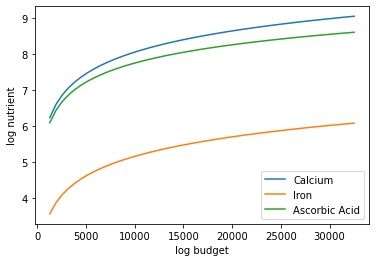

In [54]:
import numpy as np
import matplotlib.pyplot as plt

X = np.linspace(reference_x/5,reference_x*5,50)
X = X.flatten()

UseNutrients = ['Calcium', 'Iron', 'Ascorbic Acid']

df = pd.concat({myx:np.log(other_nutrient_demand(myx,p))[UseNutrients] for myx in X},axis=1).T
ax = df.plot()

ax.set_xlabel('log budget') 
ax.set_ylabel('log nutrient')

Text(0.5, 1.0, 'log price vs log nutrients of apple')

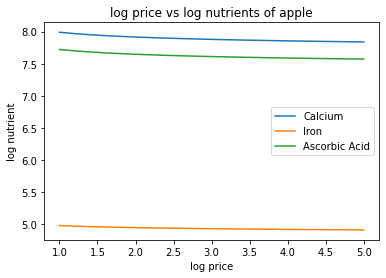

In [55]:
USE_GOOD = "apple"

ref_price = r.prices.sel(i=USE_GOOD,m=m,drop=True)

P = np.linspace(1,5,20).tolist()

ndf = pd.DataFrame({p0:np.log(other_nutrient_demand(reference_x,my_prices(p0,i=USE_GOOD)))[UseNutrients] for p0 in P}).T

ax = ndf.plot()

ax.set_xlabel('log price')
ax.set_ylabel('log nutrient') 
plt.title('log price vs log nutrients of apple')

Text(0.5, 1.0, 'log price vs log nutrients of potato')

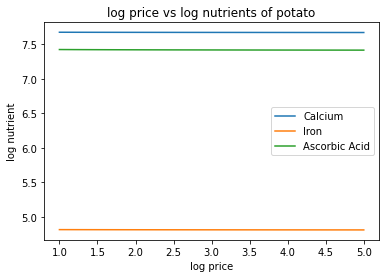

In [56]:
USE_GOOD = "potato"

ref_price = r.prices.sel(i=USE_GOOD,m=m,drop=True)

P = np.linspace(1,5,20).tolist()

ndf = pd.DataFrame({p0:np.log(other_nutrient_demand(reference_x,my_prices(p0,i=USE_GOOD)))[UseNutrients] for p0 in P}).T

ax = ndf.plot()

ax.set_xlabel('log price')
ax.set_ylabel('log nutrient') 
plt.title('log price vs log nutrients of potato')

### Nutritional Adequacy for more nutrients

In [57]:
def other_nutrient_adequacy_ratio(x,p):
    return other_nutrient_demand(x,p)/hh_rda #greater than 1 = adequate, less than 1 = less than adequate bc log of ratios

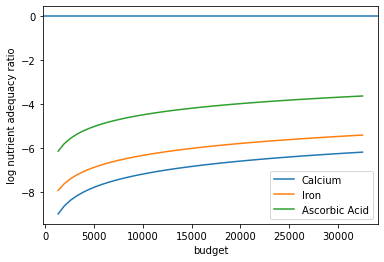

In [58]:
X = np.linspace(reference_x/5,reference_x*5,50)
X = X.flatten()
ndf = pd.concat({x:np.log(other_nutrient_adequacy_ratio(x,p))[UseNutrients] for x in X},axis=1).T

ax = (ndf-np.log(1000)).plot() #temporary fix

ax.set_xlabel('budget')
ax.set_ylabel('log nutrient adequacy ratio')
ax.axhline(0)


As we can see from the plot above, it appears that households in this region would require around 2500 rupees to consume an adequate amount of vitamin C. Based on our expenditure data from the previous section, we can see that this would take up a lot of the average household's total budget.

A very quick side note about the plots for calcium and and iron, when we looked into why the plots look like this, we found that a proportionally large amount of food items that needed to be dropped in order to generate the plot on right were calcium and iron rich, so that’s why it appears that households would be nutritionally inadequate for these items at any price. 

# Policy Changes [A] & Policy Options [B]

### Ceteris Paribus

In [59]:
import numpy as np

### First year, first market, and some good.  Change if you wish! ###
my_m = r.coords['m'].data.flatten()[0] # Market
my_i = 'apple' # r.coords['i'].data.flatten()[0] # Good
#####################################################################

p = r.prices.sel(variable=1,m=my_m,drop=True)
phat = p.to_dataframe('i').dropna().squeeze()
phat = phat*1000 #adjust because of unit issues, to reflect actual prices

ref_price = phat.loc[my_i]
P = np.linspace(ref_price/10,ref_price*5,50)

def my_prices(p0,p=phat,i=my_i):
    """
    Set price of good i to p0, holding remaining prices fixed at values in p.
    """
    p = p.copy()
    p.loc[i] = p0
    return p.squeeze()

phat

i
apple                                                75.035218
arhar (tur)                                          75.512012
besan                                                60.223086
bread (bakery)                                       49.760239
brinjal                                              14.824339
cabbage                                              10.303940
cauliflower                                          12.187999
chicken                                             121.697776
chillis (green)                                      46.695197
chira                                                24.698367
firewood & chips                                      5.032111
fish ( fresh )                                      107.222192
french beans and barbati                             18.851989
goat meat                                           256.171869
gourd, pumpkin                                        9.990976
gram (split)                                         

### Simple Policy Experiments: Changing Budget

In [60]:
# A quantile of 0.5 is the median.  Play with quantile value, or just assign.
xbar = r.get_predicted_expenditures().sel(m=my_m).sum('i')

# Drop households with /no/ predicted expenditures
xbar = xbar.where(xbar>0)

x0 = xbar.quantile(0.5,'j') # Budget (median household)
#x0 = 50


# Range of budgets to explore
X = np.linspace(x0/10,x0*5,50)

### Simple Policy Experiments: Changing Prices

#### Marshallian vs. Hicksian Demand Curves


/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings

/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings

/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')


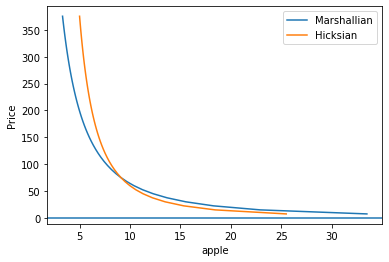

In [61]:
test = P.flatten()

import matplotlib.pyplot as plt

apple_index = 'apple'

U0 = r.indirect_utility(x0,phat)

plt.plot([r.demands(x0,my_prices(p0,i=apple_index))[apple_index] for p0 in P],P)
plt.plot([r.demands(U0,my_prices(p0,i=apple_index),type="Hicksian")[apple_index] for p0 in P],P)
plt.ylabel('Price')
plt.xlabel(apple_index)
plt.axhline(p.sel(i=apple_index).values)
plt.legend(("Marshallian","Hicksian"))

/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings

/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings

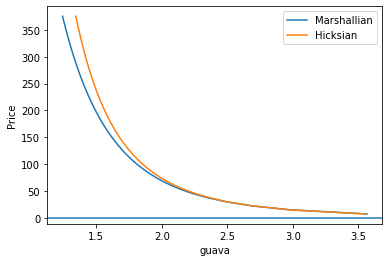

In [62]:
guava_index = 'guava'

U0 = r.indirect_utility(x0,phat)

plt.plot([r.demands(x0,my_prices(p0,i=guava_index))[guava_index] for p0 in P],P)
plt.plot([r.demands(U0,my_prices(p0,i=guava_index),type="Hicksian")[guava_index] for p0 in P],P)
plt.ylabel('Price')
plt.xlabel(guava_index)
plt.axhline(p.sel(i=guava_index).values)
plt.legend(("Marshallian","Hicksian"))

/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings

/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings

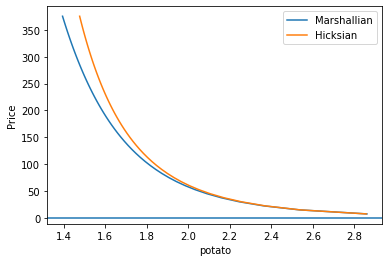

In [63]:
potato_index = 'potato'  

U0 = r.indirect_utility(x0,phat)

plt.plot([r.demands(x0,my_prices(p0,i=potato_index))[potato_index] for p0 in P],P)
plt.plot([r.demands(U0,my_prices(p0,i=potato_index),type="Hicksian")[potato_index] for p0 in P],P)
plt.ylabel('Price')
plt.xlabel(potato_index)
plt.axhline(p.sel(i=potato_index).values)
plt.legend(("Marshallian","Hicksian"))

Here we see the Marshallian and Hicksian demand curves for each of the three goods to which we are applying our price subsidy.

These three goods show some different behavior. The demand curves for the apples show that as price increases, quantity demanded falls steeply. Guava is slightly less elastic, and potatoes – a staple of the Bihar diet – are even less elastic. There is also a noticeable difference between the Marshallian and Hicksian demand curves, especially for the apples. When the prices of all three goods increase dramatically, our data shows that Bihar households would substitute these goods with others. The convergence of the two demand curves at low prices for guava and potatoes shows that these goods cannot easily be substituted away from – potatoes especially are a staple of the Bihar diet. We can see these effects more clearly on the next slide where we measure the compensating variation.
Since our policy is a price subsidy, we are changing the slope of the budget constraint and pivoting it “outward” to shift our demand curves.

#### Welfare measures

In [64]:
def compensating_variation(U0,p0,p1):
    x0 = r.expenditure(U0,p0)
    x1 = r.expenditure(U0,p1)

    return x1-x0

def revenue(U0,p0,p1,type='Marshallian'):
    """(Un)Compensated revenue from taxes changing vector of prices from p0 to p1.

    Note that this is only for *demand* side (i.e., if supply perfectly elastic).
    """
    
    dp = p1 - p0 # Change in prices

    c = r.demands(U0,p1,type=type)

    dp,c = dp.align(c,join='inner')

    return dp.T@c


def deadweight_loss(U0,p0,p1):
    """
    Deadweight loss of tax/subsidy scheme creating wedge in prices from p0 to p1.

    Note that this is only for *demand* side (i.e., if supply perfectly elastic).
    """
    cv = compensating_variation(U0,p0,p1)

    return cv - revenue(U0,p0,p1,type='Hicksian') 
    
    
def compensated_nutrient_demand(U,p,z=None):
    c = r.demands(U,p,z=z,type='Hicksian')
    fct0,c0 = fct.align(c,axis=0,join='inner')
    N = fct0.T@c0

    return N

def compensated_nutrient_adequacy_ratio(U,p):
    return (compensated_nutrient_demand(U,p)/hh_rdi.T).squeeze()

#### Price Changes, Revenue, and Compensating Variation

With these changes in prices for a few food items, we can visualize the compensation variation-- the amount of money one would have to give a consumer to offset completely the harm from a price increase in order to keep the consumer on the original indifference curve. In our policy, we would essentially decrease the price of food items rich in the nutrients necessary for an adequate diet and give money to the consumer to fully compensate them.

/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings

/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings

/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings

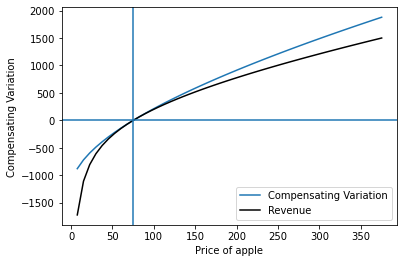

In [65]:
fig, ax1 = plt.subplots()

ax1.plot(P,[compensating_variation(U0,phat,my_prices(p0,i=apple_index)) for p0 in P])
ax1.set_xlabel("Price of %s" % apple_index)
ax1.set_ylabel("Compensating Variation")

#do a list of goods/redefine my_price function
ax1.plot(P,[revenue(U0,phat,my_prices(p0,i=apple_index),type='Hicksian') for p0 in P],'k')
ax1.legend(('Compensating Variation','Revenue'))
ax1.axhline(0)
ax1.axvline(phat.loc[apple_index])

/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings

/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings

/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings

/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')


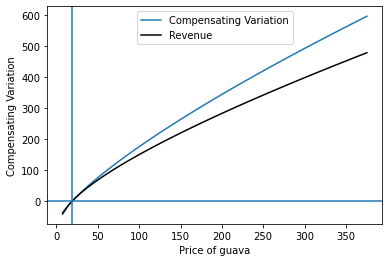

In [66]:
fig, ax1 = plt.subplots()

ax1.plot(P,[compensating_variation(U0,phat,my_prices(p0,i=guava_index)) for p0 in P])
ax1.set_xlabel("Price of %s" % guava_index)
ax1.set_ylabel("Compensating Variation")

#do a list of goods/redefine my_price function
ax1.plot(P,[revenue(U0,phat,my_prices(p0,i=guava_index),type='Hicksian') for p0 in P],'k')
ax1.legend(('Compensating Variation','Revenue'))
ax1.axhline(0)
ax1.axvline(phat.loc[guava_index])

/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings

/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings

/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings

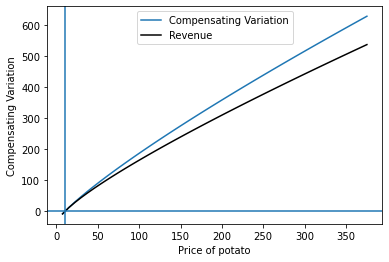

In [67]:
fig, ax1 = plt.subplots()

ax1.plot(P,[compensating_variation(U0,phat,my_prices(p0,i=potato_index)) for p0 in P])
ax1.set_xlabel("Price of %s" % potato_index)
ax1.set_ylabel("Compensating Variation")

#do a list of goods/redefine my_price function
ax1.plot(P,[revenue(U0,phat,my_prices(p0,i=potato_index),type='Hicksian') for p0 in P],'k')
ax1.legend(('Compensating Variation','Revenue'))
ax1.axhline(0)
ax1.axvline(phat.loc[potato_index])

Looking directly at the compensating variation tells us more directly what we could infer from the demand curves. As we change the price of apples, we can visualize the effect on the Bihar households. One way to measure this is through the compensating variation, which tells us how much money we would have to provide the households in income to be equivalent to the utility they gain through the price change. We are not actually changing the household income, but the compensating variation is a useful way to quantify the welfare effects of our price subsidy policy. It is clear from these three graphs that the biggest welfare benefit comes from our price subsidy on apples. As we decrease the prices of the other two goods, there is minimal welfare effect. With apples, however, we get a large welfare effect as seen in the lower left quadrant of the leftmost graph.

#### Deadweight Loss


/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings

/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings

/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings

Text(0, 0.5, 'Deadweight Loss')

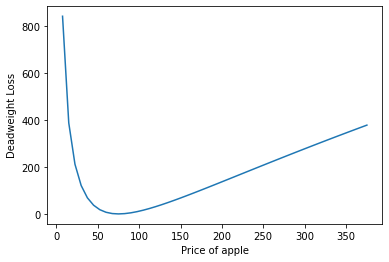

In [68]:
fig, ax1 = plt.subplots()

ax1.plot(P,[deadweight_loss(U0,phat,my_prices(p0,i=apple_index)) for p0 in P])
ax1.set_xlabel("Price of %s" % apple_index)
ax1.set_ylabel("Deadweight Loss")

/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings

/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings

/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings

Text(0, 0.5, 'Deadweight Loss')

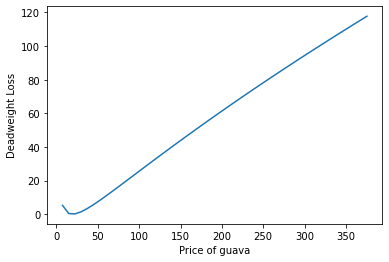

In [69]:
fig, ax1 = plt.subplots()

ax1.plot(P,[deadweight_loss(U0,phat,my_prices(p0,i=guava_index)) for p0 in P])
ax1.set_xlabel("Price of %s" % guava_index)
ax1.set_ylabel("Deadweight Loss")

/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings

/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings

/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/demands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings

Text(0, 0.5, 'Deadweight Loss')

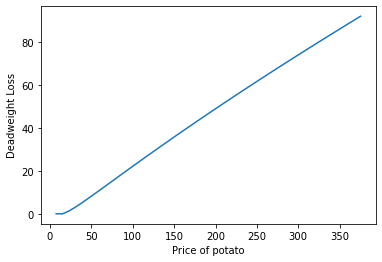

In [70]:
fig, ax1 = plt.subplots()

ax1.plot(P,[deadweight_loss(U0,phat,my_prices(p0,i=potato_index)) for p0 in P])
ax1.set_xlabel("Price of %s" % potato_index)
ax1.set_ylabel("Deadweight Loss")

One way to evaluate the costs of our policy is in terms of the resulting deadweight loss. The deadweight loss measured here tells us the inefficiency of our policy. The cost of the policy in terms of lost revenue (which in our case is born by the government agency) is greater than the welfare benefits to the consumers. However, since this is a humanitarian effort, we are willing to put up with some amount of inefficiency. But as we can see in the graph for apples, the deadweight loss increases significantly as we greatly reduce the price of apples.